# HomeWork1 - exercise 1

{('o', 'a'): Text(-0.5000055608106777, 0.4999944391893225, 'c=3'),
 ('a', 'd'): Text(0.4999944391893223, 0.5000055608106779, 'c=3'),
 ('o', 'b'): Text(-0.5000048208748922, 0.0, 'c=3'),
 ('b', 'c'): Text(0.0, -0.5000090380199254, 'c=3'),
 ('c', 'd'): Text(0.4999944391893223, -0.5000055608106775, 'c=2'),
 ('a', 'b'): Text(0.0, 0.49999096198007487, 'c=1')}

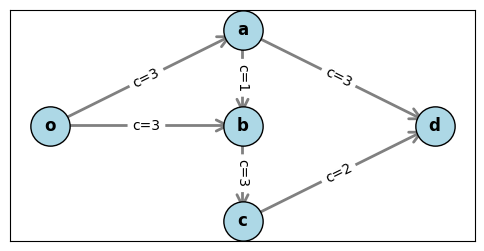

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.flow import edmonds_karp
%matplotlib inline

G = nx.DiGraph()
G.add_edges_from([("o","a"), ("a","d"), ("o","b"), ("b","c"), ("c","d"),("a","b")])

edges = [
    ("o", "a", 3),  # o -> a with capacity 3      e1
    ("a", "d", 3),  # a -> d with capacity 1      e2
    ("o", "b", 3),  # o -> b with capacity 3      e3
    ("b", "c", 3),  # b -> c with capacity 3      e4
    ("c", "d", 2),  # c -> d with capacity 1      e5
    ("a", "b", 1),  # a -> b with capacity 3      e6
]

for u, v, cap in edges:
    G.add_edge(u, v, capacity=cap)
fig, ax = plt.subplots(figsize=(6,3))

pos = {"o":[-1,0], "a":[0,1], "b":[0,0], "c":[0,-1],"d":[1,0]}
labels = {("o","a"): "e1", ("a","d"): "e2", ("o","b"): "e3", ("b","c"): "e4", ("b","c"): "e4", ("c","d"): "e5", ("a","b"): "e6"}

nx.draw_networkx_nodes(G, pos, node_size=800, node_color='lightblue', edgecolors='black')
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Draw edges with arrows
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, 
                       arrowsize=20, arrowstyle='->', width=2)

# Add capacity labels
edge_labels = {(u, v): f'c={cap}' for u, v, cap in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)


## **A)** **Compute the capacity of all the cuts and find the minimum capacity** to be removed for no feasible flow from o to d to exist.

In [2]:
import itertools

def find_all_cuts(G, source, sink):
    nodes = list(G.nodes())
    nodes.remove(source)
    nodes.remove(sink)
    
    cuts = []
    # Generate all possible subsets of remaining nodes
    for r in range(len(nodes) + 1):
        for subset in itertools.combinations(nodes, r):
            S = {source} | set(subset)
            T = set(G.nodes()) - S
            
            if sink in T:  # Valid cut
                cut_capacity = 0
                cut_edges = []
                for u in S:
                    for v in G.successors(u):
                        if v in T:
                            capacity = G[u][v]['capacity']
                            cut_capacity += capacity
                            cut_edges.append((u, v, capacity))
                cuts.append((S, T, cut_capacity, cut_edges))
    
    return cuts

In [3]:
# Example usage
all_cuts = find_all_cuts(G, "o", "d")

print("=== PART (a) ===")
print("All cuts and their capacities (sum of capacities included):")
for S, T, capacity, edges in sorted(all_cuts, key=lambda x: x[2]):
    edge_str = ', '.join([f"{u}->{v}({cap})" for u, v, cap in edges])
    total_capacity = sum(cap for _, _, cap in edges)  # sum of capacities of edges in this cut
    print(f"S: {S}, Capacity: {capacity}, Edges: [{edge_str}], Sum of capacities: {total_capacity}")

min_cut = min(all_cuts, key=lambda x: x[2])
print(f"\nMinimum cut capacity: {min_cut[2]}")
print(f"Minimum capacity to remove for no feasible flow: {min_cut[2]}")

=== PART (a) ===
All cuts and their capacities (sum of capacities included):
S: {'o', 'b', 'c'}, Capacity: 5, Edges: [o->a(3), c->d(2)], Sum of capacities: 5
S: {'o', 'a', 'b', 'c'}, Capacity: 5, Edges: [a->d(3), c->d(2)], Sum of capacities: 5
S: {'o'}, Capacity: 6, Edges: [o->a(3), o->b(3)], Sum of capacities: 6
S: {'o', 'b'}, Capacity: 6, Edges: [o->a(3), b->c(3)], Sum of capacities: 6
S: {'o', 'a', 'b'}, Capacity: 6, Edges: [a->d(3), b->c(3)], Sum of capacities: 6
S: {'o', 'a'}, Capacity: 7, Edges: [o->b(3), a->d(3), a->b(1)], Sum of capacities: 7
S: {'o', 'c'}, Capacity: 8, Edges: [o->a(3), o->b(3), c->d(2)], Sum of capacities: 8
S: {'o', 'a', 'c'}, Capacity: 9, Edges: [o->b(3), a->d(3), a->b(1), c->d(2)], Sum of capacities: 9

Minimum cut capacity: 5
Minimum capacity to remove for no feasible flow: 5


In [4]:
min_cut = min(all_cuts, key=lambda x: x[2]) #(S, T, cut_capacity, cut_edges)
min_cut

({'b', 'c', 'o'}, {'a', 'd'}, 5, [('o', 'a', 3), ('c', 'd', 2)])

## **B)** You are given $x > 0$ extra units of capacity $(x ∈ Z)$. How should you distribute them in order to maximize the throughput that can be sent from $o$ to $d$? Plot the maximum throughput from $o$ to $d$ as a function of $x ≥ 0$.

c d
o a
a d
o a
a d
o a
a d
o a
a d
o a
a d


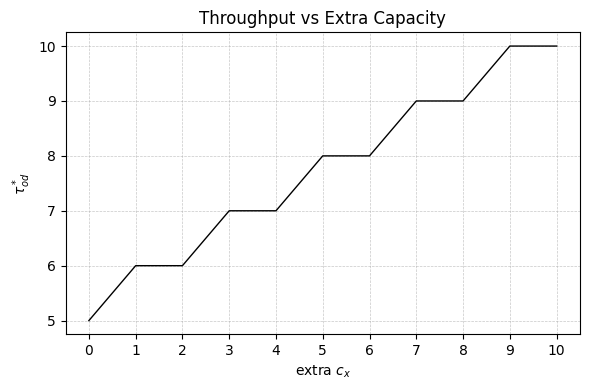

In [5]:
import networkx as nx
import itertools
import matplotlib.pyplot as plt
import copy
from collections import Counter

def maximize_throughput(G, source, sink, lim_x):
    G_current = copy.deepcopy(G)
    max_flows = []

    for _ in range(lim_x + 1):
        flow_value, _ = nx.maximum_flow(G_current, source, sink)
        max_flows.append(flow_value)

        cuts = find_all_cuts(G_current, source, sink)
        min_cut_value = min(c[2] for c in cuts)
        min_cuts = [c for c in cuts if c[2] == min_cut_value]

        # Count how many times each edge appears across all minimal cuts
        edge_counter = Counter()
        for _, _, _, edges in min_cuts:
            for u, v, cap in edges:
                edge_counter[(u, v)] += 1

        if not edge_counter:
            break

        # Pick the most frequent edge (tie-breaker optional)
        u, v = max(edge_counter, key=edge_counter.get)
        print(u,v)
        G_current[u][v]['capacity'] += 1
    return max_flows

lim_x = 10
max_flows = maximize_throughput(G, 'o', 'd', lim_x)


plt.figure(figsize=(6,4))
plt.plot(range(lim_x + 1), max_flows, color='black', linewidth=1)
plt.xlabel("extra $c_x$")
plt.ylabel("$\\tau^*_{od}$")
plt.title("Throughput vs Extra Capacity")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Show all integer values on x-axis
plt.xticks(range(lim_x + 1))
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

# Save as high-quality PNG
plt.tight_layout()
plt.savefig("throughput_vs_extra_capacity.png", format='png', dpi=300)
plt.show()

By the Max-Flow Min-Cut Theorem, we know that $$\max \text{Flow}(G) = \min_{(S,T)} c(S,T)$$ where $$c(S,T) = \sum_{(u,v)\in E,, u\in S,, v\in T} c_{uv}$$ represents the total capacity of the cut.

Therefore, increasing the capacity of any edge that belongs to a minimum cut $$(S,T)$$ will directly increase the maximum flow in the network.

If there exist multiple minimum cuts, say $${(S_i, T_i)}{i=1}^k$$, then the edges that are common to all of them — that is, those in the intersection $$\bigcap{i=1}^k E(S_i, T_i)$$ — are the most critical bottlenecks.

By increasing the capacity of such common edges by one unit, we effectively increase the maximum throughput across all minimal cuts at once.

Hence, identifying and reinforcing the edges shared among all minimum cuts is a heuristic yet powerful strategy for distributing additional capacity efficiently.

## **C)** You are given the possibility of adding to the network a directed link $e_8$ with capacity $c_8= 1$ and $x > 0$ extra units of capacity $(x ∈ Z)$. Where should you add the link and how should you distribute the additional capacity in order to maximize the throughput that can be sent from $o$ to $d$? Plot the maximum throughput from $o$ to $d$ as a function of $x ≥ 0$.

In [6]:
G.add_edge('o', 'd', capacity=1)

In [7]:
all_cuts = find_all_cuts(G, "o", "d")
print("=== PART (a) ===")
print("All cuts and their capacities:")
for S, T, capacity, edges in sorted(all_cuts, key=lambda x: x[2]):
    print(f"S: {S}, Capacity: {capacity}")

min_cut = min(all_cuts, key=lambda x: x[2])
print(f"\nMinimum cut capacity: {min_cut[2]}")
print(f"Minimum capacity to remove for no feasible flow: {min_cut[2]}")

=== PART (a) ===
All cuts and their capacities:
S: {'o', 'b', 'c'}, Capacity: 6
S: {'o', 'a', 'b', 'c'}, Capacity: 6
S: {'o'}, Capacity: 7
S: {'o', 'b'}, Capacity: 7
S: {'o', 'a', 'b'}, Capacity: 7
S: {'o', 'a'}, Capacity: 8
S: {'o', 'c'}, Capacity: 9
S: {'o', 'a', 'c'}, Capacity: 10

Minimum cut capacity: 6
Minimum capacity to remove for no feasible flow: 6


<>:42: SyntaxWarning: invalid escape sequence '\m'
<>:42: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_785587/163039135.py:42: SyntaxWarning: invalid escape sequence '\m'
  plt.title("Throughput vs Extra Capacity on $\mathcal{G}'$")


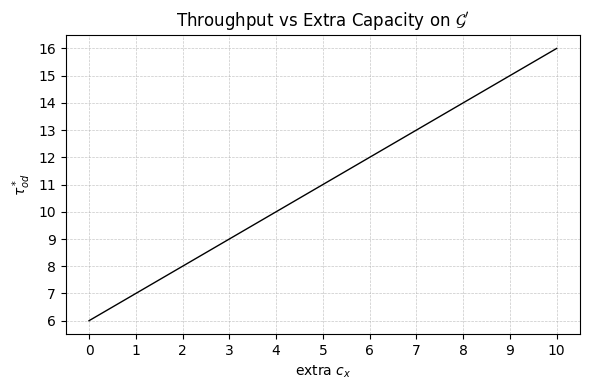

In [8]:


def maximize_throughput(G, source, sink, lim_x):
    """Distribute extra integer capacities to maximize throughput."""
    G_current = copy.deepcopy(G)

    # Step 1 — add the new edge e8 = (o, d) with capacity 1
    if not G_current.has_edge(source, sink):
        G_current.add_edge(source, sink, capacity=1)

    max_flows = []

    # Step 2 — iteratively allocate extra capacity x units
    for _ in range(lim_x + 1):
        flow_value, _ = nx.maximum_flow(G_current, source, sink)
        max_flows.append(flow_value)

        cuts = find_all_cuts(G_current, source, sink)
        min_cut_value = min(c[2] for c in cuts)
        min_cuts = [c for c in cuts if c[2] == min_cut_value]

        # Count how many times each edge appears across all minimal cuts
        edge_counter = Counter()
        for _, _, _, edges in min_cuts:
            for u, v, cap in edges:
                edge_counter[(u, v)] += 1

        if not edge_counter:
            break

        # Pick the edge that appears most often in min cuts (tie-breaker optional)
        u, v = max(edge_counter, key=edge_counter.get)
        G_current[u][v]['capacity'] += 1

    return max_flows

lim_x = 10
max_flows = maximize_throughput(G, 'o', 'd', lim_x)

plt.figure(figsize=(6,4))
plt.plot(range(lim_x + 1), max_flows, color='black', linewidth=1)
plt.xlabel("extra $c_x$")
plt.ylabel("$\\tau^*_{od}$")
plt.title("Throughput vs Extra Capacity on $\mathcal{G}'$")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)  # grid

# Show all integer values on x-axis
plt.xticks(range(lim_x + 1))

# Show all integer values on y-axis
min_y, max_y = int(min(max_flows)), int(max(max_flows))
plt.yticks(range(min_y, max_y + 1))

plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

# Save high-resolution PNG
plt.tight_layout()
plt.savefig("throughput_vs_extra_capacity.png", format='png', dpi=1200)

# Show the plot
plt.show()